In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats
from sklearn import preprocessing
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

#restart kernel
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

In [3]:
datafile="/data0/users/bpnachman/Gaia/GD1-circle-140-30-15.pkl"
gaiadata=np.load(datafile,allow_pickle=True)
gaiadata2=np.array(gaiadata[['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag']].astype('float32'))
gaiadata2 = np.vstack([gaiadata2[:,0].T,
           gaiadata2[:,1].T,
           gaiadata2[:,2].T,
           gaiadata2[:,3].T,
           (gaiadata2[:,5]-gaiadata2[:,6]).T,
           gaiadata2[:,4].T]).T
gaiadata2 = gaiadata2[np.sum(np.isnan(gaiadata2),axis=1)==0]
#if(dataset=='jhelum' or dataset=='weird'):
#    gaiadata2[:,3]=gaiadata2[:,3]-360*(gaiadata2[:,3]//180)
# Just use radius 15 circle
center_dec=0.5*(np.max(gaiadata2[:,2])+np.min(gaiadata2[:,2]))
center_ra=0.5*(np.max(gaiadata2[:,3])+np.min(gaiadata2[:,3]))
radius=np.sqrt((gaiadata2[:,2]-center_dec)**2+(gaiadata2[:,3]-center_ra)**2)
gaiadata2=gaiadata2[radius<15]
np.random.shuffle(gaiadata2)

In [4]:
gaiadata3=np.array(gaiadata[gaiadata['streammask']==1][['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag']].astype('float32'))
gaiadata3 = np.vstack([gaiadata3[:,0].T,
           gaiadata3[:,1].T,
           gaiadata3[:,2].T,
           gaiadata3[:,3].T,
           (gaiadata3[:,5]-gaiadata3[:,6]).T,
           gaiadata3[:,4].T]).T
gaiadata3 = gaiadata3[np.sum(np.isnan(gaiadata3),axis=1)==0]
#if(dataset=='jhelum' or dataset=='weird'):
#    gaiadata2[:,3]=gaiadata2[:,3]-360*(gaiadata2[:,3]//180)
# Just use radius 15 circle
#center_dec=0.5*(np.max(gaiadata3[:,2])+np.min(gaiadata3[:,2]))
#center_ra=0.5*(np.max(gaiadata3[:,3])+np.min(gaiadata3[:,3]))
radius=np.sqrt((gaiadata3[:,2]-center_dec)**2+(gaiadata3[:,3]-center_ra)**2)
gaiadata3=gaiadata3[radius<15]
np.random.shuffle(gaiadata3)

In [5]:
gaiadata2_no_gd1 = np.array(gaiadata[gaiadata['streammask']==0][['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag']].astype('float32'))
gaiadata2_no_gd1 = np.vstack([gaiadata2_no_gd1[:,0].T,
           gaiadata2_no_gd1[:,1].T,
           gaiadata2_no_gd1[:,2].T,
           gaiadata2_no_gd1[:,3].T,
           (gaiadata2_no_gd1[:,5]-gaiadata2_no_gd1[:,6]).T,
           gaiadata2_no_gd1[:,4].T]).T
gaiadata2_no_gd1 = gaiadata2_no_gd1[np.sum(np.isnan(gaiadata2_no_gd1),axis=1)==0]
#if(dataset=='jhelum' or dataset=='weird'):
#    gaiadata2[:,3]=gaiadata2[:,3]-360*(gaiadata2[:,3]//180)
# Just use radius 15 circle
#center_dec=0.5*(np.max(gaiadata3[:,2])+np.min(gaiadata3[:,2]))
#center_ra=0.5*(np.max(gaiadata3[:,3])+np.min(gaiadata3[:,3]))
radius=np.sqrt((gaiadata2_no_gd1[:,2]-center_dec)**2+(gaiadata2_no_gd1[:,3]-center_ra)**2)
gaiadata2_no_gd1=gaiadata2_no_gd1[radius<15]
np.random.shuffle(gaiadata2_no_gd1)                            

In [6]:
gaiadata.keys()

Index(['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'bp_rp', 'radial_velocity', 'radial_velocity_error',
       'teff_val', 'streammask'],
      dtype='object')

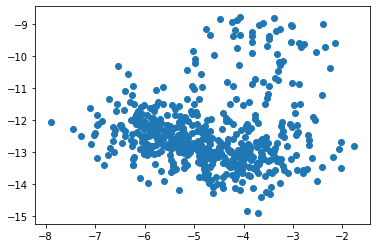

In [7]:
plt.scatter(gaiadata3[:,1],gaiadata3[:,0])

Text(0, 0.5, '$\\mu_\\delta$ [$\\mu$as/year]')

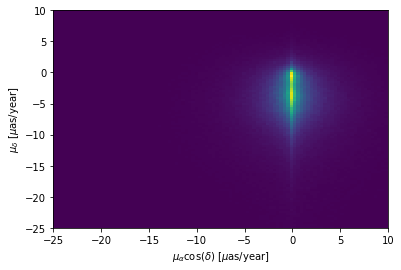

In [8]:
_,_,_,_=plt.hist2d(gaiadata2[:,1]*np.cos(gaiadata2[:,2]),gaiadata2[:,0],bins=[np.linspace(-25,10,100),np.linspace(-25,10,100)])
plt.xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]")
plt.ylabel(r"$\mu_\delta$ [$\mu$as/year]")

Text(0, 0.5, '$\\delta$ [degrees]')

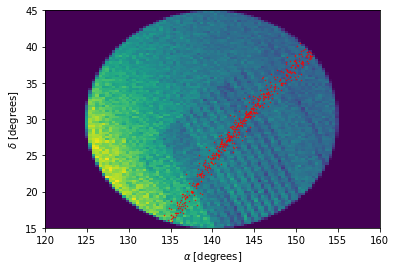

In [9]:
_,_,_,_=plt.hist2d(gaiadata2[:,3],gaiadata2[:,2],bins=[np.linspace(120,160,100),np.linspace(15,45,100)])
plt.scatter(gaiadata3[:,3],gaiadata3[:,2],color='red',s=0.2)
plt.xlabel(r"$\alpha$ [degrees]")
plt.ylabel(r"$\delta$ [degrees]")

Text(0, 0.5, '$\\delta$ [degrees]')

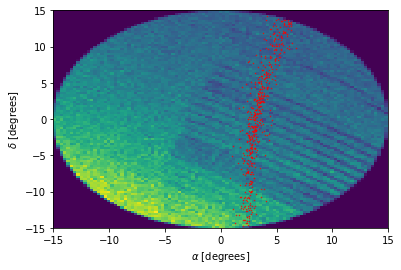

In [10]:
X = gaiadata2[:,3]-center_ra
Y = gaiadata2[:,2]-center_dec

Xs = gaiadata3[:,3]-center_ra
Ys = gaiadata3[:,2]-center_dec

theta = -0.5
Xr = X*np.cos(theta) + Y*np.sin(theta)
Yr = -X*np.sin(theta) + Y*np.cos(theta)
Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

_,_,_,_=plt.hist2d(Xr,Yr,bins=[np.linspace(-15,15,100),np.linspace(-15,15,100)])
plt.scatter(Xsr,Ysr,color='red',s=0.2)
plt.xlabel(r"$\alpha$ [degrees]")
plt.ylabel(r"$\delta$ [degrees]")

Text(0.5, 0, 'Rotated $\\delta$-$\\alpha$ space')

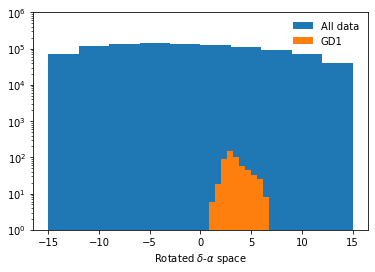

In [11]:
plt.hist(Xr,label="All data")
plt.hist(Xsr,label="GD1")
plt.yscale("log")
plt.legend(frameon=False)
plt.ylim([1,1e6])
plt.xlabel(r"Rotated $\delta$-$\alpha$ space")

Text(0.5, 0, '$\\mu_\\alpha\\cos(\\delta)$ [$\\mu$as/year]')

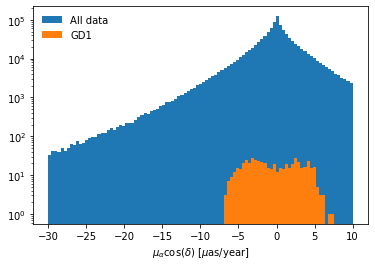

In [12]:
_,_,_=plt.hist(gaiadata2[:,1]*np.cos(gaiadata2[:,2]),bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,1]*np.cos(gaiadata3[:,2]),bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]")

Text(0.5, 0, '$\\mu_\\delta$ [$\\mu$as/year]')

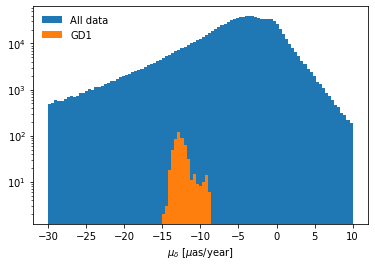

In [13]:
_,_,_=plt.hist(gaiadata2[:,0],bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,0],bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")

In [53]:
def build_data_arrays(SR, SB, GD1, theta):
    X = SR[:,3]-center_ra
    Y = SR[:,2]-center_dec

    Xr = X*np.cos(theta) + Y*np.sin(theta)
    Yr = -X*np.sin(theta) + Y*np.cos(theta)

    Xb = SB[:,3]-center_ra
    Yb = SB[:,2]-center_dec

    Xbr = Xb*np.cos(theta) + Yb*np.sin(theta)
    Ybr = -Xb*np.sin(theta) + Yb*np.cos(theta)

    Xs = GD1[:,3]-center_ra
    Ys = GD1[:,2]-center_dec

    Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
    Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

    SR = np.c_[SR[:,0],SR[:,1],Xr, Yr, SR[:,4],SR[:,5]]
    SB = np.c_[SB[:,0],SB[:,1],Xbr, Ybr, SB[:,4],SB[:,5]]
    GD1 = np.c_[GD1[:,0],GD1[:,1],Xsr, Ysr, GD1[:,4],GD1[:,5]]
    
    return SR, SB, GD1

In [60]:
def build_model(SR, SB, GD1):
    X = np.concatenate([SR,SB,GD1])
    Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(GD1))])
    X_scaled = preprocessing.scale(X)
    GD1_scaled = X_scaled[Y==2]
    X_scaled = X_scaled[Y<2]
    Y = Y[Y<2]
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)
    
    tpr_arr = []
    fpr_arr = []
    gd1_background_x_arr = []
    gd1_background_y_arr = []

    for i in range(20):

        model = Sequential()
        model.add(Dense(64, input_dim=5, activation='relu')) 
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test), verbose = 0) #fill out

        preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
        preds_SR = preds[Y_test == 1]

        preds_GD1 = model.predict(GD1_scaled[:,1:6], batch_size=int(0.1*len(GD1_scaled)))

        fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds_SR)),np.ones(len(preds_GD1))]), np.concatenate([preds_SR,preds_GD1]))
        fpr2, tpr2, thresholds2 = roc_curve(Y_test, preds)
        
        tpr_arr.append(tpr)
        fpr_arr.append(fpr)
        gd1_background_x_arr.append(tpr2)
        gd1_background_y_arr.append(fpr2)
    
    return tpr_arr, fpr_arr, gd1_background_x_arr, gd1_background_y_arr

# Test on rotated data

In [90]:
SR = gaiadata2[(gaiadata2[:,0] > -15)*(gaiadata2[:,0] < -11)]
SB = gaiadata2[(gaiadata2[:,0] > -18)*(gaiadata2[:,0] < -15)+(gaiadata2[:,0] > -11)*(gaiadata2[:,0] < -9.5)]
GD1 = gaiadata3

SR, SB, GD1 = build_data_arrays(SR, SB, GD1, -0.5)
# X = SR[:,3]-center_ra
# Y = SR[:,2]-center_dec

# theta = -0.5
# Xr = X*np.cos(theta) + Y*np.sin(theta)
# Yr = -X*np.sin(theta) + Y*np.cos(theta)

# Xb = SB[:,3]-center_ra
# Yb = SB[:,2]-center_dec

# Xbr = Xb*np.cos(theta) + Yb*np.sin(theta)
# Ybr = -Xb*np.sin(theta) + Yb*np.cos(theta)

# Xs = GD1[:,3]-center_ra
# Ys = GD1[:,2]-center_dec

# Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
# Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

# SR = np.c_[SR[:,0],Xr,SR[:,4],SR[:,5]]
# SB = np.c_[SB[:,0],Xbr,SB[:,4],SB[:,5]]
# GD1 = np.c_[GD1[:,0],Xsr,GD1[:,4],GD1[:,5]]

Text(0, 0.5, 'counts')

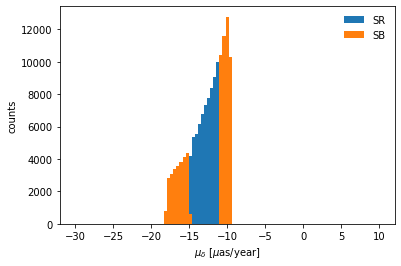

In [91]:
_,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
_,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")
plt.ylabel("counts")

In [92]:
# X = np.concatenate([SR,SB,GD1])
# Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(GD1))])
# X_scaled = preprocessing.scale(X)
# GD1_scaled = X_scaled[Y==2]
# X_scaled = X_scaled[Y<2]
# Y = Y[Y<2]
# X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

In [93]:
# sig_plots_rot_x = []
# sig_plots_rot_y = []

# for i in range(20):
    
#     #Build model
#     model = Sequential()
#     model.add(Dense(64, input_dim=3, activation='relu')) 
#     #model.add(Dropout(0.2))
#     model.add(Dense(64, activation='relu'))
#     #model.add(Dropout(0.2))
#     model.add(Dense(64, activation='relu'))
#     #model.add(Dropout(0.2))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test), verbose = 0) #fill out
    
#     #plot loss
# #     plt.clf()
# #     plt.plot(history.history['loss']) #training
# #     plt.plot(history.history['val_loss']) #testing
# #     plt.show()
    
#     #change to preds SR
#     preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
#     preds_SR = preds[Y_test == 1]
    
#     #plot
# #     plt.clf()
# #     plt.hist(preds[Y_test==1],alpha=0.5,bins=np.linspace(0,1,20),label="SR",density=True)
# #     plt.hist(preds[Y_test==0],alpha=0.5,bins=np.linspace(0,1,20),label="SB",density=True)
# #     plt.legend(frameon=False)
# #     plt.yscale("log")
# #     plt.xlabel("NN")
# #     plt.show()
    
#     preds_GD1 = model.predict(GD1_scaled[:,1:6], batch_size=int(0.1*len(GD1_scaled)))
    
#     #plot GD1 and all data
#     for cut in [0.,0.5,0.9,0.99]:
#         X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
#         X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

# #         plt.clf()
# #         plt.figure(figsize=(6,6))
# #         plt.hist(X_pass[:,1],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.hist(X_pass_GD1[:,1],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.yscale("log")
# #         plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
# #         plt.ylim([1,1e6])
# #         plt.ylabel("Counts",fontsize=20)
# #         plt.xlabel(r"Rotated $\delta$-$\alpha$ space",fontsize=20)
# #         plt.show()
    
#     from sklearn.metrics import roc_curve, auc,roc_auc_score
#     fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds_SR)),np.ones(len(preds_GD1))]), np.concatenate([preds_SR,preds_GD1]))
    
#     #plot improvement vs true positive
# #     plt.clf()
# #     plt.plot(tpr,tpr/fpr**0.5)
# #     plt.xlabel("True Positive Rate")
# #     plt.ylabel("Significance Improvement")
    
#     sig_plots_rot_x.append(tpr)
#     sig_plots_rot_y.append(tpr/fpr**0.5)
    
#     #plt.show()

#     for cut in [0.,0.5,0.9,0.99]:
#         X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
#         X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]
    
# #         plt.clf()
# #         plt.figure(figsize=(6,6))
# #         plt.hist(X_pass[:,0],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.hist(X_pass_GD1[:,0],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.yscale("log")
# #         plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
# #         plt.ylim([1,1e6])
# #         plt.ylabel("Counts",fontsize=20)
# #         plt.xlabel(r"Rotated $\delta$-$\alpha$ space",fontsize=20)
# #         plt.show()
        

In [94]:
tpr_rot, fpr_rot, tpr_rot_gd1_background, fpr_rot_gd1_background = build_model(SR, SB, GD1)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


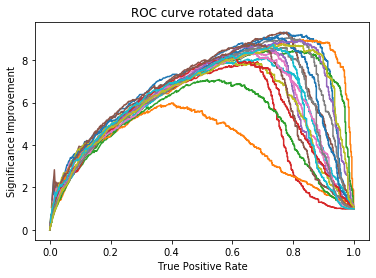

In [95]:
for x, y in zip(tpr_rot, fpr_rot):
    plt.plot(x, x/y**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.title("ROC curve rotated data")
plt.show()

# Test on data that is not rotated 

In [96]:
SR = gaiadata2[(gaiadata2[:,0] > -15)*(gaiadata2[:,0] < -11)]
SB = gaiadata2[(gaiadata2[:,0] > -18)*(gaiadata2[:,0] < -15)+(gaiadata2[:,0] > -11)*(gaiadata2[:,0] < -9.5)]
GD1 = gaiadata3

SR, SB, GD1 = build_data_arrays(SR, SB, GD1, 0)

# X = SR[:,3]-center_ra
# Y = SR[:,2]-center_dec

# theta = 0
# Xr = X*np.cos(theta) + Y*np.sin(theta)
# Yr = -X*np.sin(theta) + Y*np.cos(theta)

# Xb = SB[:,3]-center_ra
# Yb = SB[:,2]-center_dec

# Xbr = Xb*np.cos(theta) + Yb*np.sin(theta)
# Ybr = -Xb*np.sin(theta) + Yb*np.cos(theta)

# Xs = GD1[:,3]-center_ra
# Ys = GD1[:,2]-center_dec

# Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
# Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

# SR = np.c_[SR[:,0],Xr, Yr, SR[:,4],SR[:,5]]
# SB = np.c_[SB[:,0],Xbr, Ybr, SB[:,4],SB[:,5]]
# GD1 = np.c_[GD1[:,0],Xsr, Ysr, GD1[:,4],GD1[:,5]]

## Histograms for non-rotated data

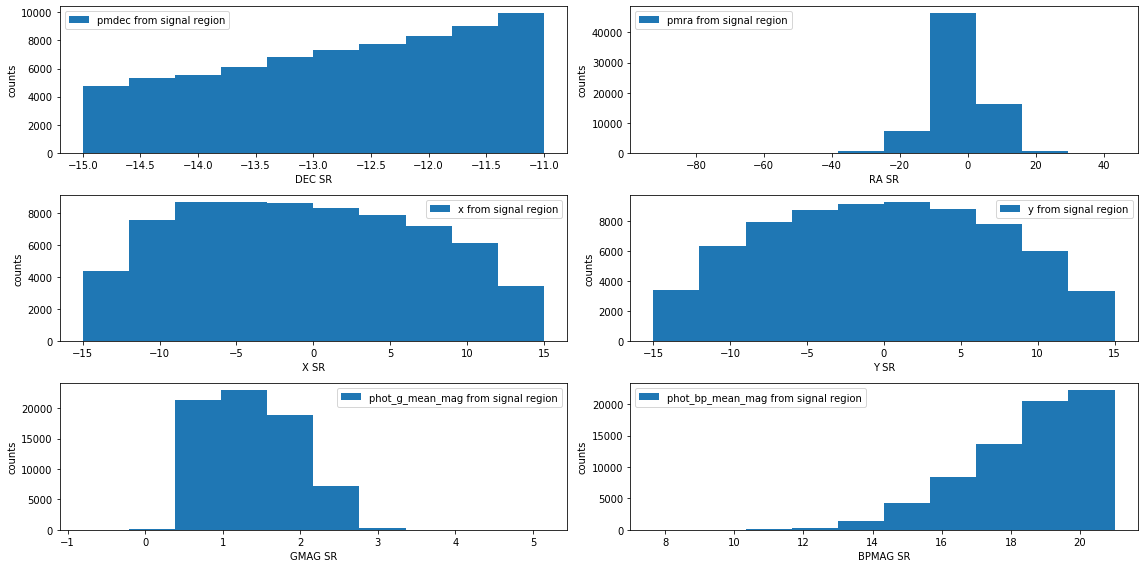

In [100]:
#SIGNAL REGION HISTOGRAMS
plt.figure(figsize = (16, 8))
plt.subplot(321)
plt.hist(SR[:, 0], label = "pmdec from signal region") 
plt.xlabel("DEC SR")
plt.ylabel("counts")
plt.legend()

plt.subplot(322)
plt.hist(SR[:, 1], label = "pmra from signal region") 
plt.xlabel("RA SR")
plt.ylabel("counts")
plt.legend()

plt.subplot(323)
plt.hist(SR[:, 2], label = "x from signal region")
plt.xlabel("X SR")
plt.ylabel("counts")
plt.legend()

plt.subplot(324)
plt.hist(SR[:, 3], label = 'y from signal region')
plt.xlabel("Y SR")
plt.ylabel("counts")
plt.legend()

plt.subplot(325)
plt.hist(SR[:, 4], label = 'phot_g_mean_mag from signal region')
plt.xlabel("GMAG SR")
plt.ylabel("counts")
plt.legend()

plt.subplot(326)
plt.hist(SR[:, 5], label = 'phot_bp_mean_mag from signal region')
plt.xlabel("BPMAG SR")
plt.ylabel("counts")
plt.legend()

plt.tight_layout()

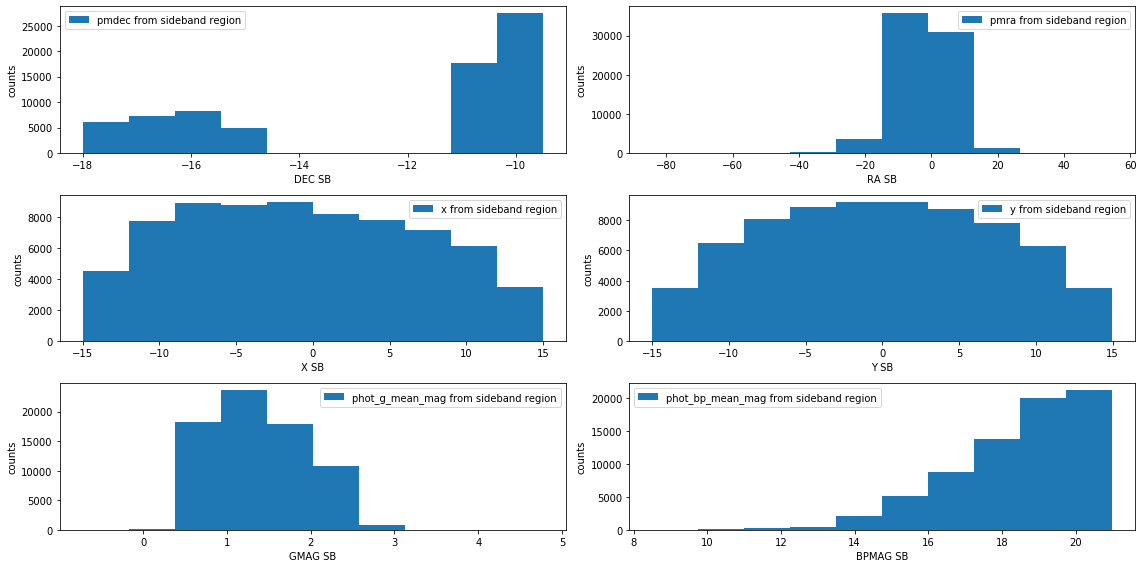

In [102]:
#SIDEBAND REGION HISTOGRAMS
plt.figure(figsize = (16, 8))
plt.subplot(321)
plt.hist(SB[:, 0], label = "pmdec from sideband region")
plt.xlabel("DEC SB")
plt.ylabel("counts")
plt.legend()

plt.subplot(322)
plt.hist(SB[:, 1], label = "pmra from sideband region")
plt.xlabel("RA SB")
plt.ylabel("counts")
plt.legend()

plt.subplot(323)
plt.hist(SB[:, 2], label = "x from sideband region")
plt.xlabel("X SB")
plt.ylabel("counts")
plt.legend()

plt.subplot(324)
plt.hist(SB[:, 3], label = 'y from sideband region')
plt.xlabel("Y SB")
plt.ylabel("counts")
plt.legend()

plt.subplot(325)
plt.hist(SB[:, 4], label = 'phot_g_mean_mag from sideband region')
plt.xlabel("GMAG SB")
plt.ylabel("counts")
plt.legend()

plt.subplot(326)
plt.hist(SB[:, 5], label = 'phot_bp_mean_mag from sideband region')
plt.xlabel("BPMAG SB")
plt.ylabel("counts")
plt.legend()

plt.tight_layout()

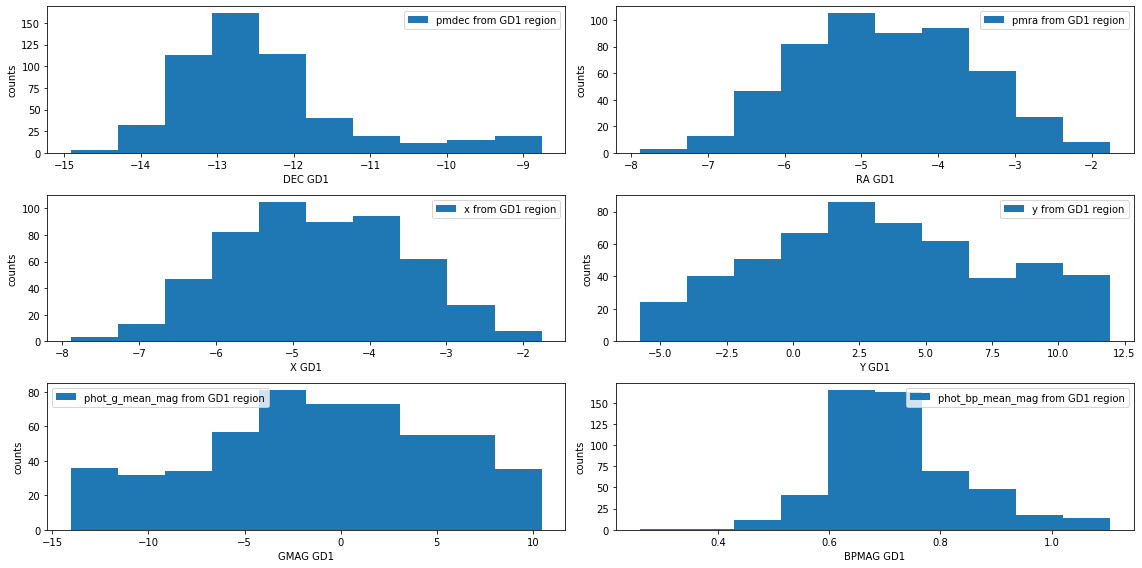

In [103]:
#OVERALL (GD1) REGION HISTOGRAMS 
plt.figure(figsize = (16, 8))
plt.subplot(321)
plt.hist(GD1[:, 0], label = "pmdec from GD1 region")
plt.xlabel("DEC GD1")
plt.ylabel("counts")
plt.legend()

plt.subplot(322)
plt.hist(GD1[:, 1], label = "pmra from GD1 region")
plt.xlabel("RA GD1")
plt.ylabel("counts")
plt.legend()

plt.subplot(323)
plt.hist(GD1[:, 1], label = "x from GD1 region")
plt.xlabel("X GD1")
plt.ylabel("counts")
plt.legend()

plt.subplot(324)
plt.hist(GD1[:, 2], label = 'y from GD1 region')
plt.xlabel("Y GD1")
plt.ylabel("counts")
plt.legend()

plt.subplot(325)
plt.hist(GD1[:, 3], label = 'phot_g_mean_mag from GD1 region')
plt.xlabel("GMAG GD1")
plt.ylabel("counts")
plt.legend()

plt.subplot(326)
plt.hist(GD1[:, 4], label = 'phot_bp_mean_mag from GD1 region')
plt.xlabel("BPMAG GD1")
plt.ylabel("counts")
plt.legend()

plt.tight_layout()

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


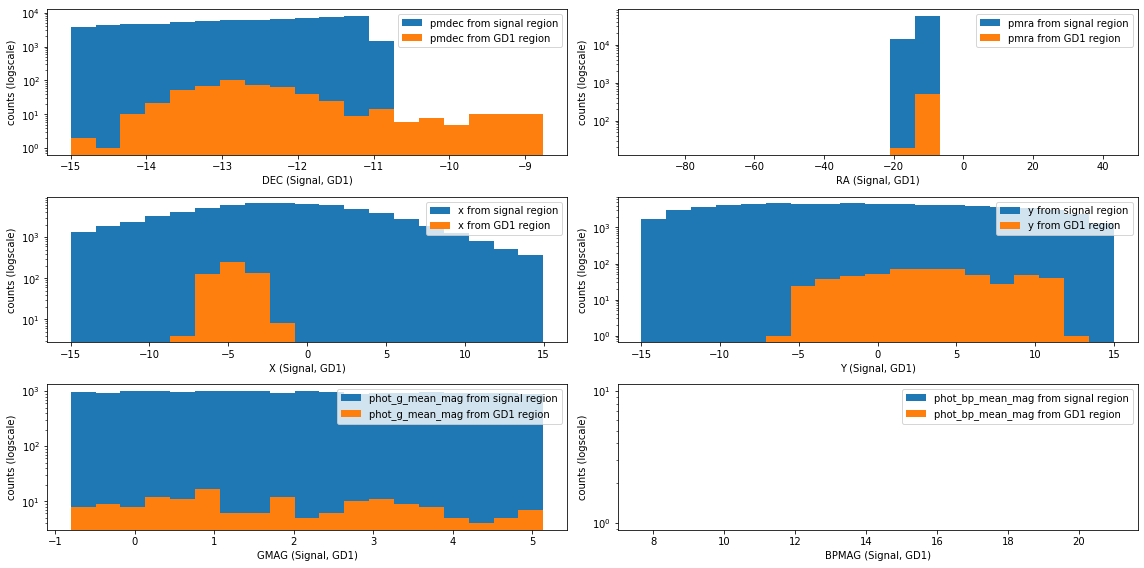

In [104]:
#OVERLAY SIGNAL AND GD1 HISTOGRAMS
plt.figure(figsize = (16, 8))
plt.subplot(321)
min_b = min(min(SR[:, 0]), min(GD1[:, 0]))
max_b = max(max(SR[:, 0]), max(GD1[:, 0]))
plt.hist(SR[:, 0], bins = np.linspace(min_b, max_b, 20), label = "pmdec from signal region") 
plt.hist(GD1[:, 0], bins = np.linspace(min_b, max_b, 20), label = "pmdec from GD1 region")
plt.xlabel("DEC (Signal, GD1)")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.subplot(322)
min_b = min(min(SR[:, 1]), min(GD1[:, 1]))
max_b = max(max(SR[:, 1]), max(GD1[:, 1]))
plt.hist(SR[:, 0], bins = np.linspace(min_b, max_b, 20), label = "pmra from signal region") 
plt.hist(GD1[:, 0], bins = np.linspace(min_b, max_b, 20), label = "pmra from GD1 region")
plt.xlabel("RA (Signal, GD1)")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.subplot(323)
min_b = min(min(SR[:, 2]), min(GD1[:, 2]))
max_b = max(max(SR[:, 2]), max(GD1[:, 2]))
plt.hist(SR[:, 1], bins = np.linspace(min_b, max_b, 20), label = "x from signal region")
plt.hist(GD1[:, 1], bins = np.linspace(min_b, max_b, 20), label = "x from GD1 region")
plt.xlabel("X (Signal, GD1)")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.subplot(324)
min_b = min(min(SR[:, 3]), min(GD1[:, 3]))
max_b = max(max(SR[:, 3]), max(GD1[:, 3]))
plt.hist(SR[:, 2], bins = np.linspace(min_b, max_b, 20), label = 'y from signal region')
plt.hist(GD1[:, 2], bins = np.linspace(min_b, max_b, 20), label = 'y from GD1 region')
plt.xlabel("Y (Signal, GD1)")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.subplot(325)
min_b = min(min(SR[:, 4]), min(GD1[:, 4]))
max_b = max(max(SR[:, 4]), max(GD1[:, 4]))
plt.hist(SR[:, 3], bins = np.linspace(min_b, max_b, 20), label = 'phot_g_mean_mag from signal region')
plt.hist(GD1[:, 3], bins = np.linspace(min_b, max_b, 20), label = 'phot_g_mean_mag from GD1 region')
plt.xlabel("GMAG (Signal, GD1)")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.subplot(326)
min_b = min(min(SR[:, 5]), min(GD1[:, 5]))
max_b = max(max(SR[:, 5]), max(GD1[:, 5]))
plt.hist(SR[:,4], bins = np.linspace(min_b, max_b, 20), label = 'phot_bp_mean_mag from signal region')
plt.hist(GD1[:,4], bins = np.linspace(min_b, max_b, 20), label = 'phot_bp_mean_mag from GD1 region')
plt.xlabel("BPMAG (Signal, GD1)")
plt.ylabel("counts (logscale)")
plt.yscale('log')
plt.legend()

plt.tight_layout()

Text(0, 0.5, 'RA GD1')

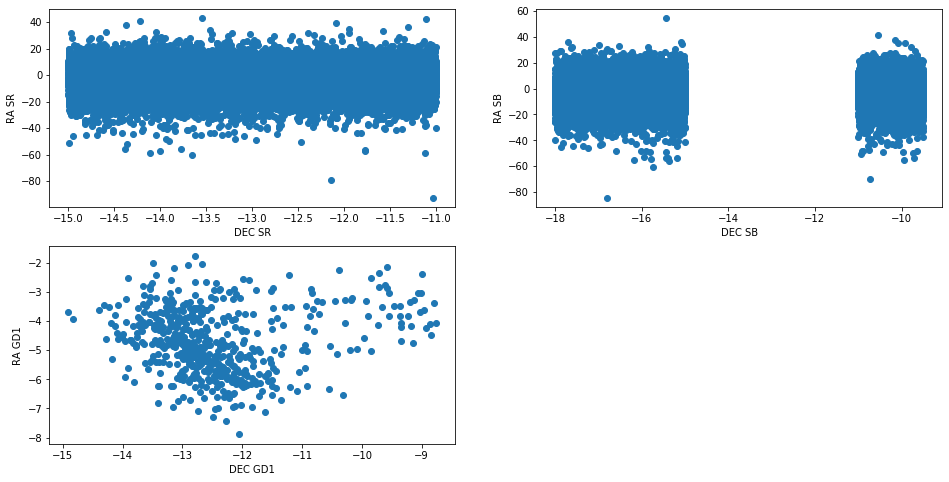

In [105]:
#PLOT DEC VS RA
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 0], SR[:, 1])
plt.xlabel("DEC SR")
plt.ylabel("RA SR")

plt.subplot(222)
plt.scatter(SB[:, 0], SB[:, 1])
plt.xlabel("DEC SB")
plt.ylabel("RA SB")

plt.subplot(223)
plt.scatter(GD1[: ,0], GD1[:, 1])
plt.xlabel("DEC GD1")
plt.ylabel("RA GD1")

Text(0, 0.5, 'X GD1')

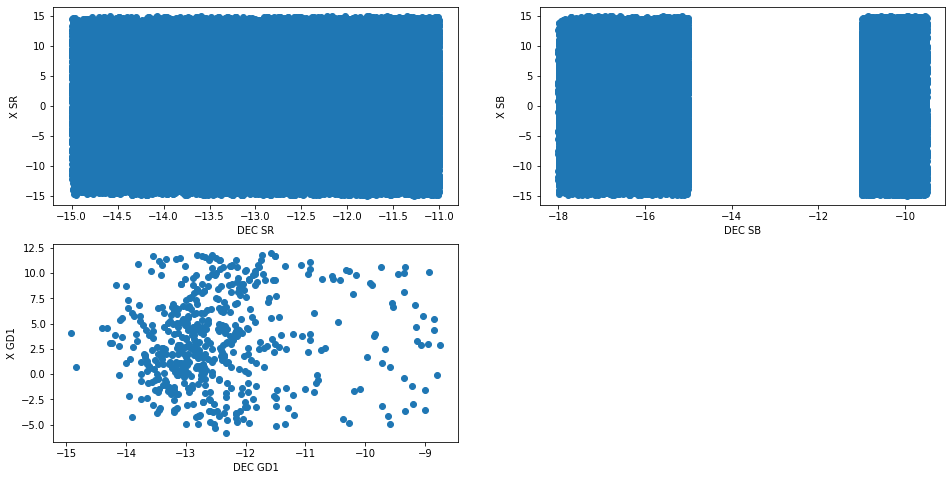

In [106]:
#PLOT DEC VS X
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 0], SR[:, 2])
plt.xlabel("DEC SR")
plt.ylabel("X SR")

plt.subplot(222)
plt.scatter(SB[:, 0], SB[:, 2])
plt.xlabel("DEC SB")
plt.ylabel("X SB")

plt.subplot(223)
plt.scatter(GD1[: ,0], GD1[:, 2])
plt.xlabel("DEC GD1")
plt.ylabel("X GD1")

Text(0, 0.5, 'Y GD1')

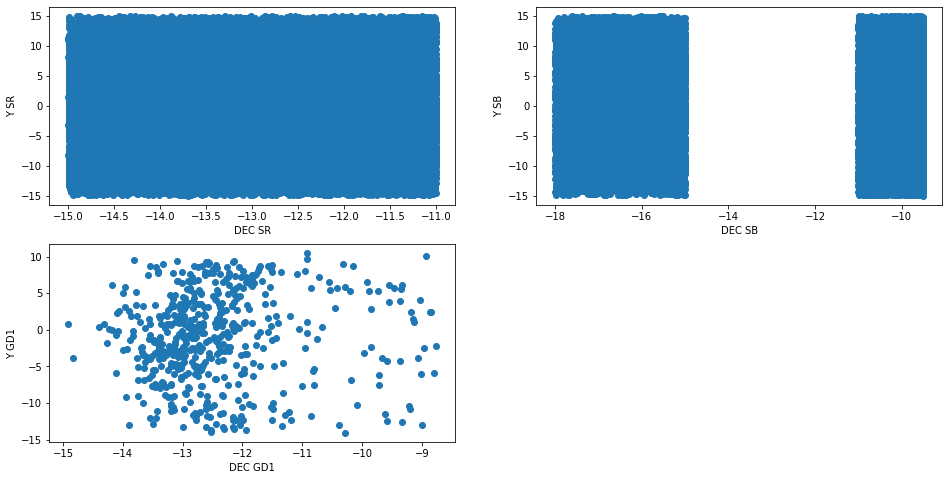

In [107]:
#PLOT DEC VS Y
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 0], SR[:, 3])
plt.xlabel("DEC SR")
plt.ylabel("Y SR")

plt.subplot(222)
plt.scatter(SB[:, 0], SB[:, 3])
plt.xlabel("DEC SB")
plt.ylabel("Y SB")

plt.subplot(223)
plt.scatter(GD1[: ,0], GD1[:, 3])
plt.xlabel("DEC GD1")
plt.ylabel("Y GD1")

Text(0, 0.5, 'GMAG GD1')

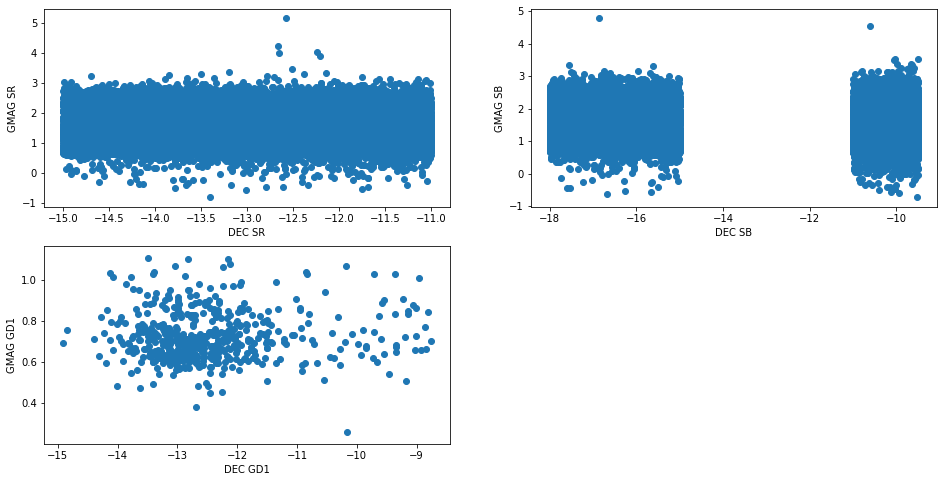

In [108]:
#PLOT DEC VS GMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 0], SR[:, 4])
plt.xlabel("DEC SR")
plt.ylabel("GMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 0], SB[:, 4])
plt.xlabel("DEC SB")
plt.ylabel("GMAG SB")

plt.subplot(223)
plt.scatter(GD1[: ,0], GD1[:, 4])
plt.xlabel("DEC GD1")
plt.ylabel("GMAG GD1")

Text(0, 0.5, 'BPMAG GD1')

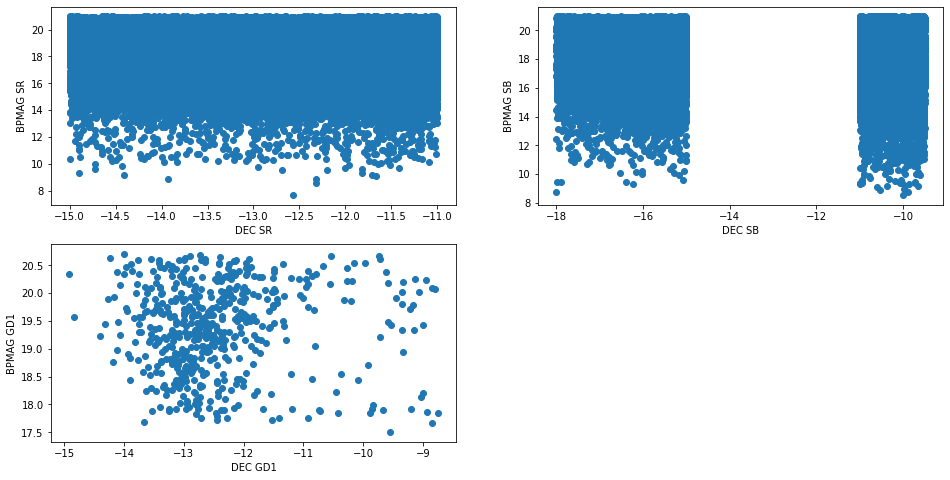

In [109]:
#PLOT DEC VS BPMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 0], SR[:, 5])
plt.xlabel("DEC SR")
plt.ylabel("BPMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 0], SB[:, 5])
plt.xlabel("DEC SB")
plt.ylabel("BPMAG SB")

plt.subplot(223)
plt.scatter(GD1[: ,0], GD1[:, 5])
plt.xlabel("DEC GD1")
plt.ylabel("BPMAG GD1")

Text(0, 0.5, 'X GD1')

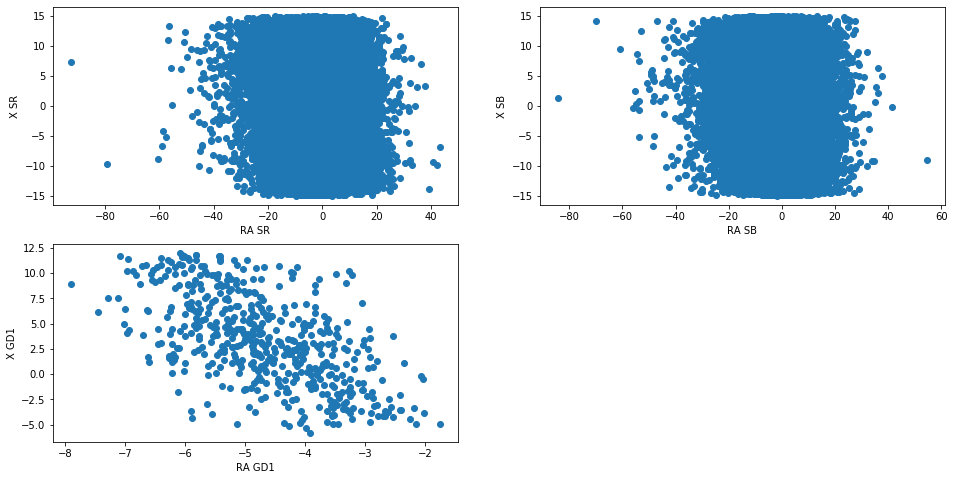

In [110]:
#PLOT RA VS X
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 1], SR[:, 2])
plt.xlabel("RA SR")
plt.ylabel("X SR")

plt.subplot(222)
plt.scatter(SB[:, 1], SB[:, 2])
plt.xlabel("RA SB")
plt.ylabel("X SB")

plt.subplot(223)
plt.scatter(GD1[: ,1], GD1[:, 2])
plt.xlabel("RA GD1")
plt.ylabel("X GD1")

Text(0, 0.5, 'Y GD1')

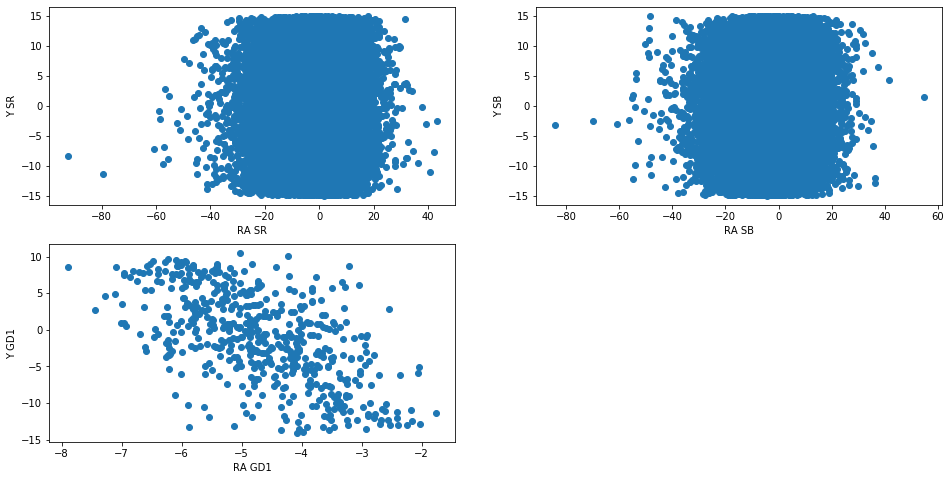

In [111]:
#PLOT RA VS Y
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 1], SR[:, 3])
plt.xlabel("RA SR")
plt.ylabel("Y SR")

plt.subplot(222)
plt.scatter(SB[:, 1], SB[:, 3])
plt.xlabel("RA SB")
plt.ylabel("Y SB")

plt.subplot(223)
plt.scatter(GD1[: ,1], GD1[:, 3])
plt.xlabel("RA GD1")
plt.ylabel("Y GD1")

Text(0, 0.5, 'GMAG GD1')

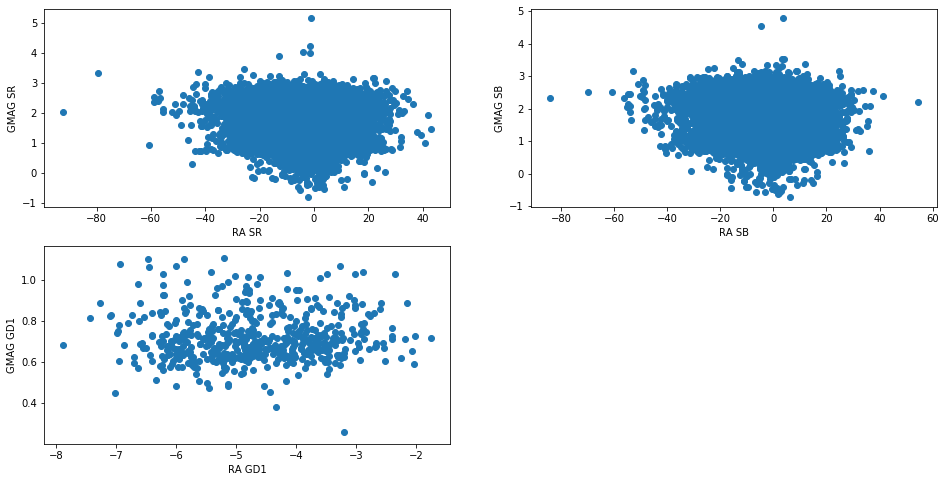

In [112]:
#PLOT RA VS GMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 1], SR[:, 4])
plt.xlabel("RA SR")
plt.ylabel("GMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 1], SB[:, 4])
plt.xlabel("RA SB")
plt.ylabel("GMAG SB")

plt.subplot(223)
plt.scatter(GD1[: ,1], GD1[:, 4])
plt.xlabel("RA GD1")
plt.ylabel("GMAG GD1")

Text(0, 0.5, 'BPMAG GD1')

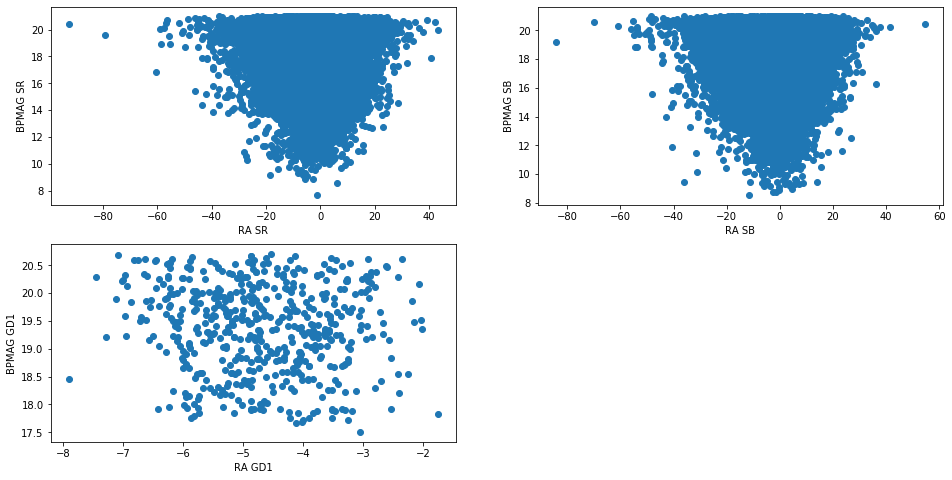

In [113]:
#PLOT RA VS GMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 1], SR[:, 5])
plt.xlabel("RA SR")
plt.ylabel("BPMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 1], SB[:, 5])
plt.xlabel("RA SB")
plt.ylabel("BPMAG SB")

plt.subplot(223)
plt.scatter(GD1[: ,1], GD1[:, 5])
plt.xlabel("RA GD1")
plt.ylabel("BPMAG GD1")

Text(0, 0.5, 'Y GD1')

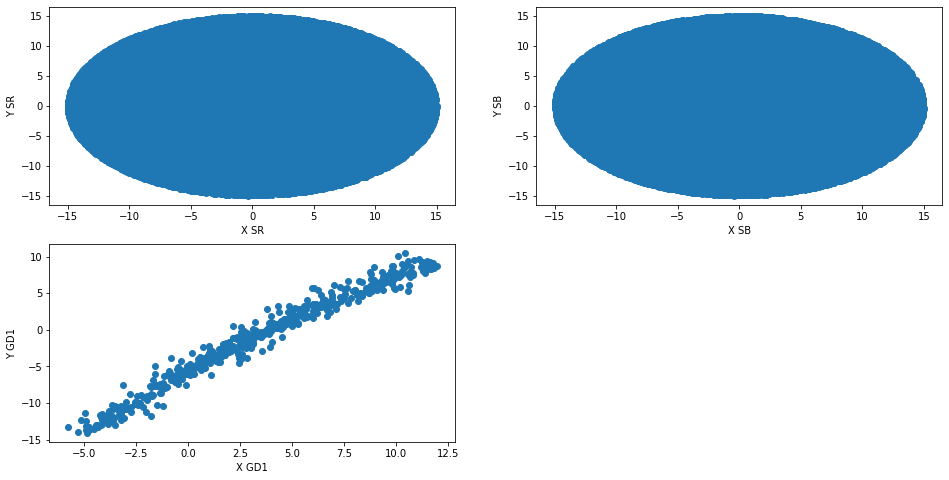

In [114]:
#PLOT X VS Y
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 2], SR[:, 3])
plt.xlabel("X SR")
plt.ylabel("Y SR")

plt.subplot(222)
plt.scatter(SB[:, 2], SB[:, 3])
plt.xlabel("X SB")
plt.ylabel("Y SB")

plt.subplot(223)
plt.scatter(GD1[:, 2], GD1[:, 3])
plt.xlabel("X GD1")
plt.ylabel("Y GD1")

Text(0, 0.5, 'GMAG GD1')

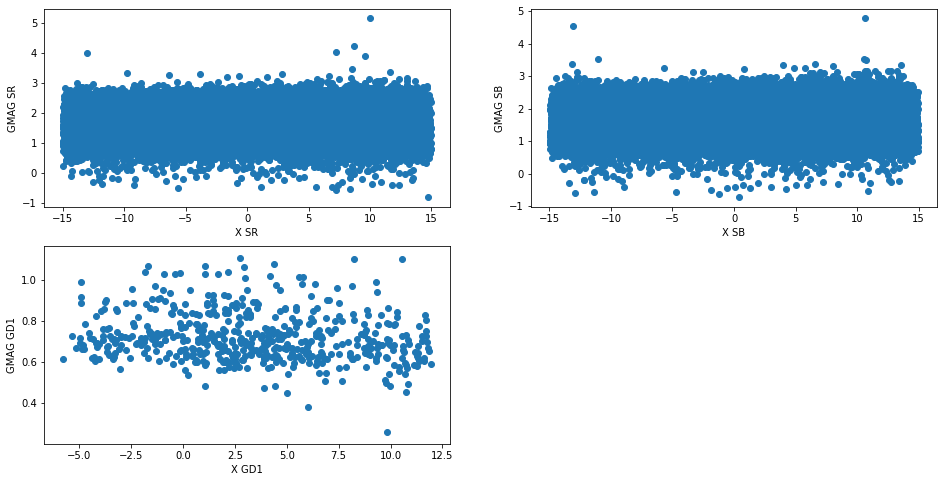

In [115]:
#PLOT X VS GMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 2], SR[:, 4])
plt.xlabel("X SR")
plt.ylabel("GMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 2], SB[:, 4])
plt.xlabel("X SB")
plt.ylabel("GMAG SB")

plt.subplot(223)
plt.scatter(GD1[:, 2], GD1[:, 4])
plt.xlabel("X GD1")
plt.ylabel("GMAG GD1")

Text(0, 0.5, 'BPMAG GD1')

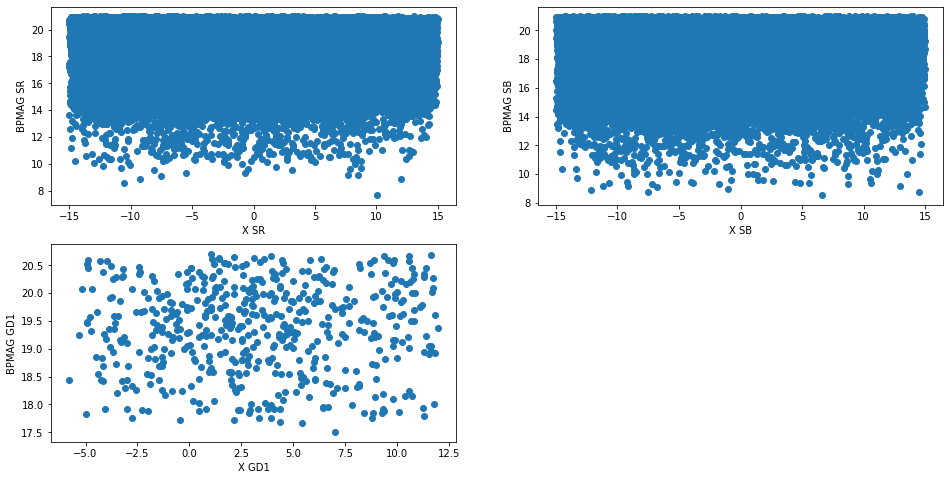

In [116]:
#PLOT X VS BPMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 2], SR[:, 5])
plt.xlabel("X SR")
plt.ylabel("BPMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 2], SB[:, 5])
plt.xlabel("X SB")
plt.ylabel("BPMAG SB")

plt.subplot(223)
plt.scatter(GD1[:, 2], GD1[:, 5])
plt.xlabel("X GD1")
plt.ylabel("BPMAG GD1")

Text(0, 0.5, 'GMAG GD1')

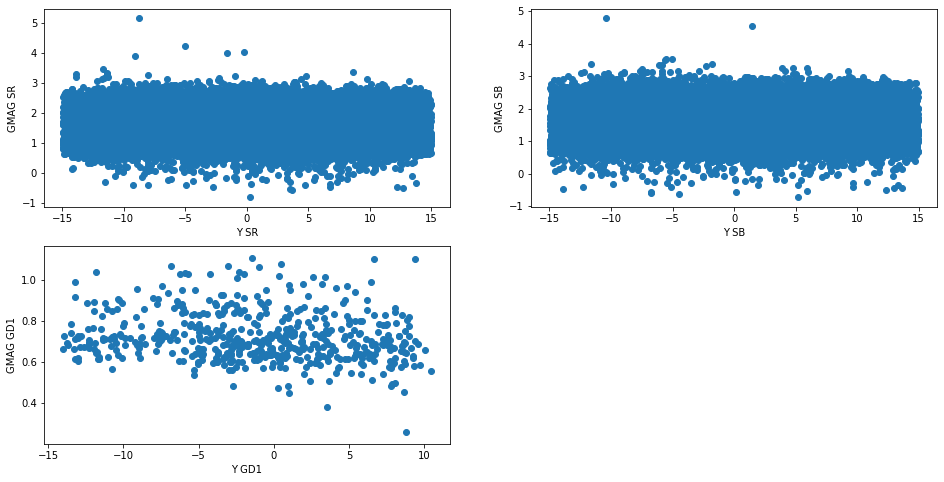

In [117]:
#PLOT Y VS GMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 3], SR[:, 4])
plt.xlabel("Y SR")
plt.ylabel("GMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 3], SB[:, 4])
plt.xlabel("Y SB")
plt.ylabel("GMAG SB")

plt.subplot(223)
plt.scatter(GD1[:, 3], GD1[:, 4])
plt.xlabel("Y GD1")
plt.ylabel("GMAG GD1")

Text(0, 0.5, 'BPMAG GD1')

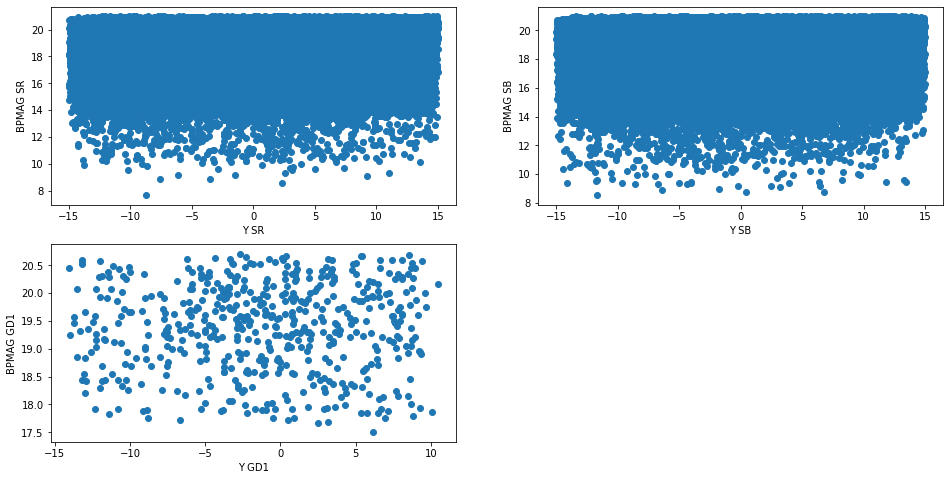

In [118]:
#PLOT Y VS BPMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 3], SR[:, 5])
plt.xlabel("Y SR")
plt.ylabel("BPMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 3], SB[:, 5])
plt.xlabel("Y SB")
plt.ylabel("BPMAG SB")

plt.subplot(223)
plt.scatter(GD1[:, 3], GD1[:, 5])
plt.xlabel("Y GD1")
plt.ylabel("BPMAG GD1")

Text(0, 0.5, 'BPMAG GD1')

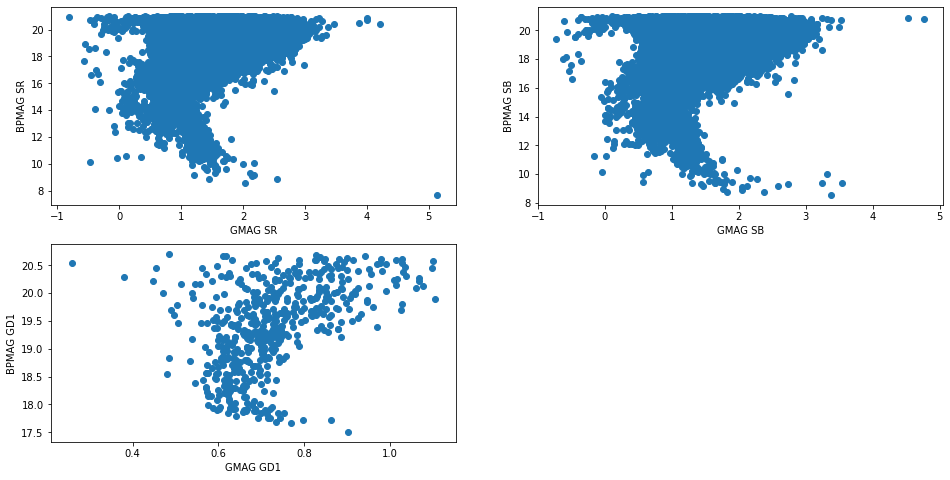

In [119]:
#PLOT GMAG VS BPMAG
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.scatter(SR[:, 4], SR[:, 5])
plt.xlabel("GMAG SR")
plt.ylabel("BPMAG SR")

plt.subplot(222)
plt.scatter(SB[:, 4], SB[:, 5])
plt.xlabel("GMAG SB")
plt.ylabel("BPMAG SB")

plt.subplot(223)
plt.scatter(GD1[:, 4], GD1[:, 5])
plt.xlabel("GMAG GD1")
plt.ylabel("BPMAG GD1")

Text(0, 0.5, 'counts')

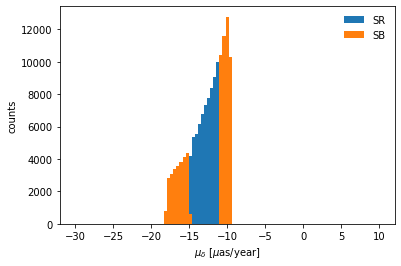

In [120]:
_,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
_,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")
plt.ylabel("counts")

In [121]:
# X = np.concatenate([SR,SB,GD1])
# Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(GD1))])
# X_scaled = preprocessing.scale(X)
# GD1_scaled = X_scaled[Y==2]
# X_scaled = X_scaled[Y<2]
# Y = Y[Y<2]
# X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

In [122]:
# sig_plots_no_rot_x = []
# sig_plots_no_rot_y = []

# for _ in range(20):
#     model = Sequential()
#     model.add(Dense(64, input_dim=4, activation='relu')) 
#     #model.add(Dropout(0.2))
#     model.add(Dense(64, activation='relu'))
#     #model.add(Dropout(0.2))
#     model.add(Dense(64, activation='relu'))
#     #model.add(Dropout(0.2))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test), verbose = 0)

#     #plot loss
# #     plt.clf()
# #     plt.plot(history.history['loss']) #training
# #     plt.plot(history.history['val_loss']) #testing
# #     plt.show()

#     #change to preds SR
#     preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
#     preds_SR = preds[Y_test == 1]

#     #plot
# #     plt.clf()
# #     plt.hist(preds[Y_test==1],alpha=0.5,bins=np.linspace(0,1,20),label="SR",density=True)
# #     plt.hist(preds[Y_test==0],alpha=0.5,bins=np.linspace(0,1,20),label="SB",density=True)
# #     plt.legend(frameon=False)
# #     plt.yscale("log")
# #     plt.xlabel("NN")
# #     plt.show()

#     preds_GD1 = model.predict(GD1_scaled[:,1:6], batch_size=int(0.1*len(GD1_scaled)))

#     #plot GD1 and all data
#     for cut in [0.,0.5,0.9,0.99]:
#         X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
#         X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

# #         plt.clf()
# #         plt.figure(figsize=(6,6))
# #         plt.hist(X_pass[:,1],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.hist(X_pass_GD1[:,1],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.yscale("log")
# #         plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
# #         plt.ylim([1,1e6])
# #         plt.ylabel("Counts",fontsize=20)
# #         plt.xlabel(r"$\delta$-$\alpha$ space",fontsize=20)
# #         plt.show()

#     from sklearn.metrics import roc_curve, auc,roc_auc_score
#     fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds_SR)),np.ones(len(preds_GD1))]), np.concatenate([preds_SR,preds_GD1]))

#     #plot improvement vs true positive
# #     plt.clf()
# #     plt.plot(tpr,tpr/fpr**0.5)
# #     plt.xlabel("True Positive Rate")
# #     plt.ylabel("Significance Improvement")
    
#     sig_plots_no_rot_x.append(tpr)
#     sig_plots_no_rot_y.append(tpr/fpr**0.5)
    
# #     plt.show()


#     for cut in [0.,0.5,0.9,0.99]:
#         X_pas = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
#         X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

# #         plt.clf()
# #         plt.figure(figsize=(6,6))
# #         plt.hist(X_pass[:,0],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.hist(X_pass_GD1[:,0],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.yscale("log")
# #         plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
# #         plt.ylim([1,1e6])
# #         plt.ylabel("Counts",fontsize=20)
# #         plt.xlabel(r"$\delta$-$\alpha$ space",fontsize=20)
# #         plt.show()

In [123]:
tpr_no_rot, fpr_no_rot, tpr_no_rot_gd1_background, fpr_no_rot_gd1_background = build_model(SR, SB, GD1)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


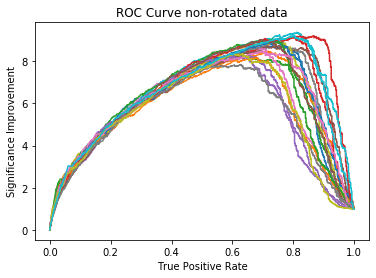

In [124]:
for x, y in zip(tpr_no_rot, fpr_no_rot):
    plt.plot(x, x/y**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.title("ROC Curve non-rotated data")
plt.show()

# Remove GD1

In [125]:
#remove GD1 
SR = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -15)*(gaiadata2_no_gd1[:,0] < -11)]
SB = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -18)*(gaiadata2_no_gd1[:,0] < -15)+(gaiadata2_no_gd1[:,0] > -11)*(gaiadata2_no_gd1[:,0] < -9.5)]
GD1 = gaiadata3

SR, SB, GD1 = build_data_arrays(SR, SB, GD1, 0)

# X = SR[:,3]-center_ra
# Y = SR[:,2]-center_dec

# theta = 0
# Xr = X*np.cos(theta) + Y*np.sin(theta)
# Yr = -X*np.sin(theta) + Y*np.cos(theta)

# Xb = SB[:,3]-center_ra
# Yb = SB[:,2]-center_dec

# Xbr = Xb*np.cos(theta) + Yb*np.sin(theta)
# Ybr = -Xb*np.sin(theta) + Yb*np.cos(theta)

# Xs = GD1[:,3]-center_ra
# Ys = GD1[:,2]-center_dec

# Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
# Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

# SR = np.c_[SR[:,0],Xr, Yr, SR[:,4],SR[:,5]]
# SB = np.c_[SB[:,0],Xbr, Ybr, SB[:,4],SB[:,5]]
# GD1 = np.c_[GD1[:,0],Xsr, Ysr, GD1[:,4],GD1[:,5]]

# X = np.concatenate([SR,SB,GD1])
# Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(GD1))])
# X_scaled = preprocessing.scale(X)
# GD1_scaled = X_scaled[Y==2]
# X_scaled = X_scaled[Y<2]
# Y = Y[Y<2]
# X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

In [126]:
# sig_plots_no_gd1_x = []
# sig_plots_no_gd1_y = []

# sig_plots_x_2 = []
# sig_plots_y_2 = []

# for _ in range(20):
#     model = Sequential()
#     model.add(Dense(64, input_dim=4, activation='relu')) 
#     #model.add(Dropout(0.2))
#     model.add(Dense(64, activation='relu'))
#     #model.add(Dropout(0.2))
#     model.add(Dense(64, activation='relu'))
#     #model.add(Dropout(0.2))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test), verbose = 0)

#     #plot loss
# #     plt.clf()
# #     plt.plot(history.history['loss']) #training
# #     plt.plot(history.history['val_loss']) #testing
# #     plt.show()

#     preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
#     preds_SR = preds[Y_test == 1]

#     #plot
# #     plt.clf()
# #     plt.hist(preds[Y_test==1],alpha=0.5,bins=np.linspace(0,1,20),label="SR",density=True)
# #     plt.hist(preds[Y_test==0],alpha=0.5,bins=np.linspace(0,1,20),label="SB",density=True)
# #     plt.legend(frameon=False)
# #     plt.yscale("log")
# #     plt.xlabel("NN")
# #     plt.show()

#     preds_GD1 = model.predict(GD1_scaled[:,1:6], batch_size=int(0.1*len(GD1_scaled)))

#     #plot GD1 and all data
#     for cut in [0.,0.5,0.9,0.99]:
#         X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
#         X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

# #         plt.clf()
# #         plt.figure(figsize=(6,6))
# #         plt.hist(X_pass[:,1],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.hist(X_pass_GD1[:,1],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.yscale("log")
# #         plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
# #         plt.ylim([1,1e6])
# #         plt.ylabel("Counts",fontsize=20)
# #         plt.xlabel(r"$\delta$-$\alpha$ space",fontsize=20)
# #         plt.show()

#     from sklearn.metrics import roc_curve, auc,roc_auc_score
#     #use preds sr
#     fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds_SR)),np.ones(len(preds_GD1))]), np.concatenate([preds_SR,preds_GD1]))
#     fpr2, tpr2, thresholds2 = roc_curve(Y_test, preds)
    
#     #add plot for fpr2, tpr2



#     #plot improvement vs true positive
# #     plt.clf()
# #     plt.plot(tpr,tpr/fpr**0.5)
# #     plt.xlabel("True Positive Rate")
# #     plt.ylabel("Significance Improvement")
    
#     sig_plots_no_gd1_x.append(tpr)
#     sig_plots_no_gd1_y.append(tpr/fpr**0.5)
    
#     sig_plots_x_2.append(tpr2)
#     sig_plots_y_2.append(tpr2/fpr2**0.5)
    
#     plt.show()

#     for cut in [0.,0.5,0.9,0.99]:
#         X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
#         X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

# #         plt.clf()
# #         plt.figure(figsize=(6,6))
# #         plt.hist(X_pass[:,0],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.hist(X_pass_GD1[:,0],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.yscale("log")
# #         plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
# #         plt.ylim([1,1e6])
# #         plt.ylabel("Counts",fontsize=20)
# #         plt.xlabel(r"$\delta$-$\alpha$ space",fontsize=20)
# #         plt.show()

In [127]:
tpr_no_gd1, fpr_no_gd1, tpr_no_gd1_gd1_background, fpr_no_gd1_gd1_background = build_model(SR, SB, GD1)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


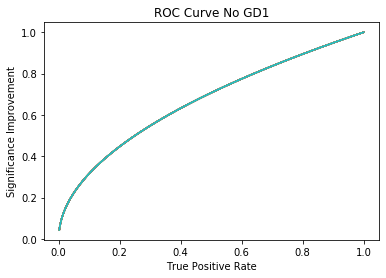

In [128]:
for x, y in zip(tpr_no_gd1, tpr_no_gd1):
    plt.plot(x, x/y**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.title("ROC Curve No GD1")
plt.show()

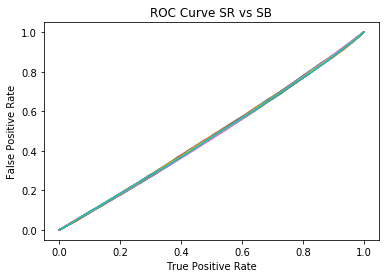

In [129]:
for x, y in zip(tpr_no_gd1_gd1_background, fpr_no_gd1_gd1_background):
    plt.plot(x, y)
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve SR vs SB")
plt.show()

## Signal and sideband without GD1, signal shifted to right

In [137]:
#remove GD1 

#sideband on each side of signal, roughly same size
SR = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -11) * (gaiadata2_no_gd1[:,0] < -6)]
SB = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -6)*(gaiadata2_no_gd1[:,0] < -4)+(gaiadata2_no_gd1[:,0] > -11)*(gaiadata2_no_gd1[:,0] < -9.5)]
GD1 = gaiadata3

SR, SB, GD1 = build_data_arrays(SR, SB, GD1, 0)

# X = SR[:,3]-center_ra
# Y = SR[:,2]-center_dec

# theta = 0
# Xr = X*np.cos(theta) + Y*np.sin(theta)
# Yr = -X*np.sin(theta) + Y*np.cos(theta)

# Xb = SB[:,3]-center_ra
# Yb = SB[:,2]-center_dec

# Xbr = Xb*np.cos(theta) + Yb*np.sin(theta)
# Ybr = -Xb*np.sin(theta) + Yb*np.cos(theta)

# Xs = GD1[:,3]-center_ra
# Ys = GD1[:,2]-center_dec

# Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
# Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

# SR = np.c_[SR[:,0],Xr, Yr, SR[:,4],SR[:,5]]
# SB = np.c_[SB[:,0],Xbr, Ybr, SB[:,4],SB[:,5]]
# GD1 = np.c_[GD1[:,0],Xsr, Ysr, GD1[:,4],GD1[:,5]]

# X = np.concatenate([SR,SB,GD1])
# Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(GD1))])
# X_scaled = preprocessing.scale(X)
# GD1_scaled = X_scaled[Y==2]
# X_scaled = X_scaled[Y<2]
# Y = Y[Y<2]
# X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

Text(0, 0.5, 'counts')

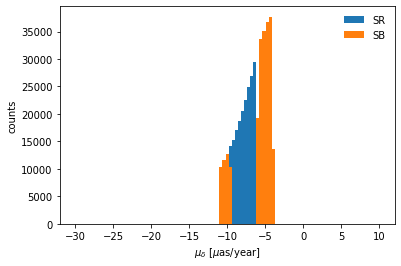

In [138]:
_,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
_,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")
plt.ylabel("counts")

In [139]:
# sig_plots_no_gd1_x_sr_right = []
# sig_plots_no_gd1_y_sr_right = []

# sig_plots_no_gd1_x_sr_right_2 = []
# sig_plots_no_gd1_y_sr_right_2 = []

# for _ in range(20):
#     model = Sequential()
#     model.add(Dense(64, input_dim=4, activation='relu')) 
#     #model.add(Dropout(0.2))
#     model.add(Dense(64, activation='relu'))
#     #model.add(Dropout(0.2))
#     model.add(Dense(64, activation='relu'))
#     #model.add(Dropout(0.2))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test), verbose = 0)

#     #plot loss
# #     plt.clf()
# #     plt.plot(history.history['loss']) #training
# #     plt.plot(history.history['val_loss']) #testing
# #     plt.show()

#     preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
#     preds_SR = preds[Y_test == 1]

#     #plot
# #     plt.clf()
# #     plt.hist(preds[Y_test==1],alpha=0.5,bins=np.linspace(0,1,20),label="SR",density=True)
# #     plt.hist(preds[Y_test==0],alpha=0.5,bins=np.linspace(0,1,20),label="SB",density=True)
# #     plt.legend(frameon=False)
# #     plt.yscale("log")
# #     plt.xlabel("NN")
# #     plt.show()

#     preds_GD1 = model.predict(GD1_scaled[:,1:6], batch_size=int(0.1*len(GD1_scaled)))

#     #plot GD1 and all data
#     for cut in [0.,0.5,0.9,0.99]:
#         X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
#         X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

# #         plt.clf()
# #         plt.figure(figsize=(6,6))
# #         plt.hist(X_pass[:,1],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.hist(X_pass_GD1[:,1],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.yscale("log")
# #         plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
# #         plt.ylim([1,1e6])
# #         plt.ylabel("Counts",fontsize=20)
# #         plt.xlabel(r"$\delta$-$\alpha$ space",fontsize=20)
# #         plt.show()

#     from sklearn.metrics import roc_curve, auc,roc_auc_score
#     #use preds sr
#     fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds_SR)),np.ones(len(preds_GD1))]), np.concatenate([preds_SR,preds_GD1]))
#     fpr2, tpr2, thresholds2 = roc_curve(Y_test, preds)
    
#     #add plot for fpr2, tpr2



#     #plot improvement vs true positive
# #     plt.clf()
# #     plt.plot(tpr,tpr/fpr**0.5)
# #     plt.xlabel("True Positive Rate")
# #     plt.ylabel("Significance Improvement")

#     sig_plots_no_gd1_x_sr_right.append(tpr)
#     sig_plots_no_gd1_y_sr_right.append(tpr/fpr**0.5)
    
#     sig_plots_no_gd1_x_sr_right_2.append(tpr2)
#     sig_plots_no_gd1_y_sr_right_2.append(fpr2)
    
#     plt.show()

#     for cut in [0.,0.5,0.9,0.99]:
#         X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
#         X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

# #         plt.clf()
# #         plt.figure(figsize=(6,6))
# #         plt.hist(X_pass[:,0],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.hist(X_pass_GD1[:,0],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.yscale("log")
# #         plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
# #         plt.ylim([1,1e6])
# #         plt.ylabel("Counts",fontsize=20)
# #         plt.xlabel(r"$\delta$-$\alpha$ space",fontsize=20)
# #         plt.show()

In [140]:
tpr_no_gd1_sr_right, fpr_no_gd1_sr_right, tpr_no_gd1_sr_right_gd1_background, fpr_no_gd1_sr_right_gd1_background = build_model(SR, SB, GD1)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


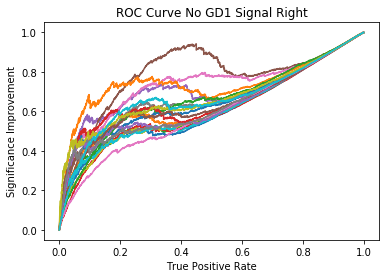

In [141]:
for x, y in zip(tpr_no_gd1_sr_right, fpr_no_gd1_sr_right):
    plt.plot(x, x/y**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.title("ROC Curve No GD1 Signal Right")
plt.show()

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


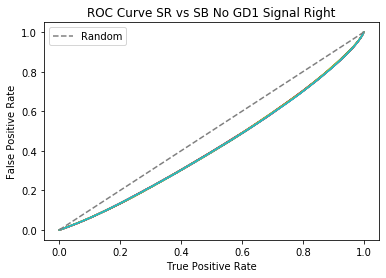

In [142]:
for x, y in zip(tpr_no_gd1_sr_right_gd1_background, fpr_no_gd1_sr_right_gd1_background):
    plt.plot(x, y)
plt.plot([0, 1], [0, 1], 'gray', ls = '--', label = 'Random')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve SR vs SB No GD1 Signal Right")
plt.show()

## Removing half of GD1

In [198]:
#remove GD1 
#vectorized programming
import random
gaiadata_half_gd1 = gaiadata2_no_gd1
for i in range(len(gaiadata3)):
    if random.randint(0, 10) < 5:
        gaiadata_half_gd1 = np.append(gaiadata_half_gd1, [gaiadata3[i]], 0)
SR = gaiadata_half_gd1[(gaiadata_half_gd1[:,0] > -15)*(gaiadata_half_gd1[:,0] < -11)]
SB = gaiadata_half_gd1[(gaiadata_half_gd1[:,0] > -18)*(gaiadata_half_gd1[:,0] < -15)+(gaiadata_half_gd1[:,0] > -11)*(gaiadata_half_gd1[:,0] < -9.5)]
GD1 = gaiadata3

SR, SB, GD1 = build_data_arrays(SR, SB, GD1)

# X = SR[:,3]-center_ra
# Y = SR[:,2]-center_dec

# theta = 0
# Xr = X*np.cos(theta) + Y*np.sin(theta)
# Yr = -X*np.sin(theta) + Y*np.cos(theta)

# Xb = SB[:,3]-center_ra
# Yb = SB[:,2]-center_dec

# Xbr = Xb*np.cos(theta) + Yb*np.sin(theta)
# Ybr = -Xb*np.sin(theta) + Yb*np.cos(theta)

# Xs = GD1[:,3]-center_ra
# Ys = GD1[:,2]-center_dec

# Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
# Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

# SR = np.c_[SR[:,0],Xr, Yr, SR[:,4],SR[:,5]]
# SB = np.c_[SB[:,0],Xbr, Ybr, SB[:,4],SB[:,5]]
# GD1 = np.c_[GD1[:,0],Xsr, Ysr, GD1[:,4],GD1[:,5]]

# X = np.concatenate([SR,SB,GD1])
# Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(GD1))])
# X_scaled = preprocessing.scale(X)
# GD1_scaled = X_scaled[Y==2]
# X_scaled = X_scaled[Y<2]
# Y = Y[Y<2]
# X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Text(0, 0.5, 'counts')

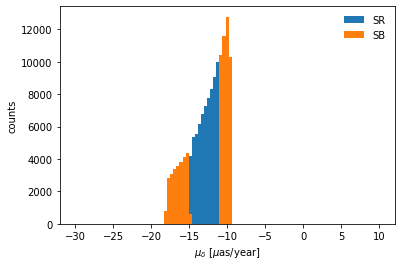

In [199]:
_,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
_,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")
plt.ylabel("counts")

In [200]:
# sig_plots_half_gd1_x = []
# sig_plots_half_gd1_y = []

# for _ in range(20):
#     model = Sequential()
#     model.add(Dense(64, input_dim=4, activation='relu')) 
#     #model.add(Dropout(0.2))
#     model.add(Dense(64, activation='relu'))
#     #model.add(Dropout(0.2))
#     model.add(Dense(64, activation='relu'))
#     #model.add(Dropout(0.2))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test), verbose = 0)

#     #plot loss
# #     plt.clf()
# #     plt.plot(history.history['loss']) #training
# #     plt.plot(history.history['val_loss']) #testing
# #     plt.show()

#     preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
#     preds_SR = preds[Y_test == 1]

#     #plot
# #     plt.clf()
# #     plt.hist(preds[Y_test==1],alpha=0.5,bins=np.linspace(0,1,20),label="SR",density=True)
# #     plt.hist(preds[Y_test==0],alpha=0.5,bins=np.linspace(0,1,20),label="SB",density=True)
# #     plt.legend(frameon=False)
# #     plt.yscale("log")
# #     plt.xlabel("NN")
# #     plt.show()

#     preds_GD1 = model.predict(GD1_scaled[:,1:6], batch_size=int(0.1*len(GD1_scaled)))

#     #plot GD1 and all data
#     for cut in [0.,0.5,0.9,0.99]:
#         X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
#         X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

# #         plt.clf()
# #         plt.figure(figsize=(6,6))
# #         plt.hist(X_pass[:,1],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.hist(X_pass_GD1[:,1],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.yscale("log")
# #         plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
# #         plt.ylim([1,1e6])
# #         plt.ylabel("Counts",fontsize=20)
# #         plt.xlabel(r"$\delta$-$\alpha$ space",fontsize=20)
# #         plt.show()

#     from sklearn.metrics import roc_curve, auc,roc_auc_score
#     #use preds sr
#     fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds_SR)),np.ones(len(preds_GD1))]), np.concatenate([preds_SR,preds_GD1]))
    
#     #add plot for fpr2, tpr2



#     #plot improvement vs true positive
# #     plt.clf()
# #     plt.plot(tpr,tpr/fpr**0.5)
# #     plt.xlabel("True Positive Rate")
# #     plt.ylabel("Significance Improvement")
    
#     sig_plots_half_gd1_x.append(tpr)
#     sig_plots_half_gd1_y.append(tpr/fpr**0.5)
    
#     plt.show()

#     for cut in [0.,0.5,0.9,0.99]:
#         X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
#         X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

# #         plt.clf()
# #         plt.figure(figsize=(6,6))
# #         plt.hist(X_pass[:,0],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.hist(X_pass_GD1[:,0],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
# #         plt.yscale("log")
# #         plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
# #         plt.ylim([1,1e6])
# #         plt.ylabel("Counts",fontsize=20)
# #         plt.xlabel(r"$\delta$-$\alpha$ space",fontsize=20)
# #         plt.show()

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
tpr_half_gd1, fpr_half_gd1, tpr_half_gd1_gd1_background, fpr_half_gd1_gd1_background = build_model(SR, SB, GD1)

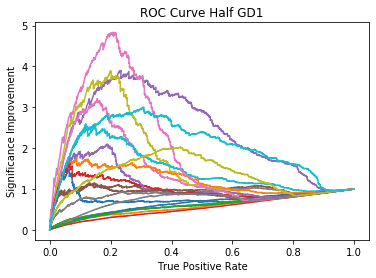

In [201]:
for x, y in zip(tpr_half_gd1, fpr_half_gd1):
    plt.plot(x, x/y**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.title("ROC Curve Half GD1")
plt.show()

In [203]:
#make a plot showing function of fraction 
#at a given fraction, put max of significance improvement (20 per fraction)
#at least four points
#add labels and titles and legends

[1.4852893448402027, 1.0009048240272207, 1.000480382072722, 1.000070601026627, 3.8995347522199144, 1.1504414848762299, 3.2094559529521836, 1.0324761322175042, 3.895447551683127, 2.5954798404286397, 1.0042770153900848, 1.7711323694653651, 1.0005369431368525, 1.6287222074106984, 2.0992808321491645, 1.1179093928436044, 4.835361822778794, 1.0004238305998185, 2.02897280418556, 3.003168588129795]
[3.9767693568407974, 2.2968183536171933, 1.122306118246564, 1.5648372113764282, 5.2571667921699765, 6.069356745533067, 4.923803453192489, 5.444163912514643, 4.448371065483277, 6.073258227338988, 5.801334398652616, 2.4864173986210223, 2.7264296629692817, 3.4804677303978018, 4.948645783203572, 5.9205878011176685, 2.945215496651144, 4.425803727937296, 4.171567976291976, 5.9297013663712255]


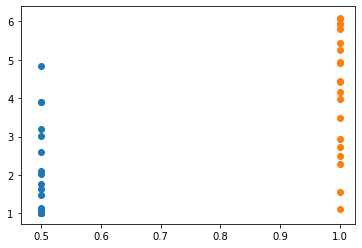

In [204]:
print([max(y[~np.isnan(y)]) for y in sig_plots_half_gd1_y])
print([max(y[~np.isnan(y)]) for y in sig_plots_no_rot_y])
plt.scatter([0.5]*20, [max(y[~np.isnan(y)]) for y in sig_plots_half_gd1_y])
plt.scatter([1.0]*20, [max(y[~np.isnan(y)]) for y in sig_plots_no_rot_y])

In [231]:
gaiadata_fractions_gd1 = np.zeros((len(fractions), 20))
print(gaiadata_fractions_gd1)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Portions of GD1

In [ ]:
fractions = [250, 500, 750]
gaiadata_fractions_gd1 = [[] for x in fractions]
tpr_fractions = [[] for x in fractions]
fpr_fractions = [[] for x in fractions]
tpr_fractions_gd1_background = [[] for x in fractions]
fpr_fractions_gd1_background = [[] for x in fractions]

import random
for counter in range(len(fractions)):
    print(counter)
    gaiadata_fractions_gd1[counter] = gaiadata2_no_gd1
    
    for i in range(len(gaiadata3)):
        if random.randint(0, 1000) < fractions[counter]:
            gaiadata_fractions_gd1[counter] = np.append(gaiadata_fractions_gd1[counter], [gaiadata3[i]], 0)
    
    SR = gaiadata_fractions_gd1[counter][(gaiadata_fractions_gd1[counter][:,0] > -15)*(gaiadata_fractions_gd1[counter][:,0] < -11)]
    SB = gaiadata_fractions_gd1[counter][(gaiadata_fractions_gd1[counter][:,0] > -18)*(gaiadata_fractions_gd1[counter][:,0] < -15)+(gaiadata_fractions_gd1[counter][:,0] > -11)*(gaiadata_fractions_gd1[counter][:,0] < -9.5)]
    GD1 = gaiadata3

    SR, SB, GD1 = build_data_arrays(SR, SB, GD1, 0)
#     X = SR[:,3]-center_ra
#     Y = SR[:,2]-center_dec

#     theta = 0
#     Xr = X*np.cos(theta) + Y*np.sin(theta)
#     Yr = -X*np.sin(theta) + Y*np.cos(theta)

#     Xb = SB[:,3]-center_ra
#     Yb = SB[:,2]-center_dec

#     Xbr = Xb*np.cos(theta) + Yb*np.sin(theta)
#     Ybr = -Xb*np.sin(theta) + Yb*np.cos(theta)

#     Xs = GD1[:,3]-center_ra
#     Ys = GD1[:,2]-center_dec

#     Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
#     Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

#     SR = np.c_[SR[:,0],Xr, Yr, SR[:,4],SR[:,5]]
#     SB = np.c_[SB[:,0],Xbr, Ybr, SB[:,4],SB[:,5]]
#     GD1 = np.c_[GD1[:,0],Xsr, Ysr, GD1[:,4],GD1[:,5]]

    tpr_fractions[counter], fpr_fractions[counter], tpr_fractions_gd1_background[counter], fpr_fractions_gd1_background[counter] = build_model(SR, SB, GD1)

#     X = np.concatenate([SR,SB,GD1])
#     Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(GD1))])
#     X_scaled = preprocessing.scale(X)
#     GD1_scaled = X_scaled[Y==2]
#     X_scaled = X_scaled[Y<2]
#     Y = Y[Y<2]
#     X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

#     for _ in range(20):
#         model = Sequential()
#         model.add(Dense(64, input_dim=4, activation='relu')) 
#         model.add(Dense(64, activation='relu'))
#         model.add(Dense(64, activation='relu'))
#         model.add(Dense(1, activation='sigmoid'))
#         model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#         history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test), verbose = 0)

#         preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
#         preds_SR = preds[Y_test == 1]

#         preds_GD1 = model.predict(GD1_scaled[:,1:6], batch_size=int(0.1*len(GD1_scaled)))

#         #plot GD1 and all data
#         for cut in [0.,0.5,0.9,0.99]:
#             X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
#             X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

#         from sklearn.metrics import roc_curve, auc,roc_auc_score
#         #use preds sr
#         fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds_SR)),np.ones(len(preds_GD1))]), np.concatenate([preds_SR,preds_GD1]))

#         sig_plots_fractions_gd1_x[counter].append(tpr)
#         sig_plots_fractions_gd1_y[counter].append(tpr/fpr**0.5)

#         for cut in [0.,0.5,0.9,0.99]:
#             X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
#             X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

0


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


1


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


2


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [180]:
sig_improvements = gaiadata_fractions_gd1 = [[] for x in range(len(fractions)+1)]
sig_improvements[0] = [x/y**0.5 for x, y in zip(tpr_fractions[0], fpr_fractions[0])]
sig_improvements[1] = [x/y**0.5 for x, y in zip(tpr_fractions[1], fpr_fractions[1])]
sig_improvements[2] = [x/y**0.5 for x, y in zip(tpr_fractions[2], fpr_fractions[2])]
sig_improvements[3] = [x/y**0.5 for x, y in zip(tpr_no_rot, fpr_no_rot)]

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


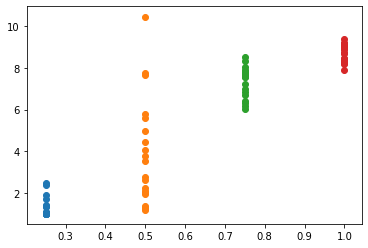

In [187]:
plt.scatter([0.25]*20, [max(y[np.isfinite(y)]) for y in sig_improvements[0]])
plt.scatter([0.5]*20, [max(y[np.isfinite(y)]) for y in sig_improvements[1]])
plt.scatter([0.75]*20, [max(y[np.isfinite(y)]) for y in sig_improvements[2]])
plt.scatter([1.0]*20, [max(y[np.isfinite(y)]) for y in sig_improvements[3]])
#box and whisker?
#add labels

In [182]:
# plt.scatter([0.25]*20, [max(y[~np.isnan(y)]) for y in sig_plots_fractions_gd1_y[0]])
# plt.scatter([0.5]*20, [max(y[~np.isnan(y)]) for y in sig_plots_fractions_gd1_y[1]])
# plt.scatter([0.75]*20, [max(y[~np.isnan(y)]) for y in sig_plots_fractions_gd1_y[2]])
# plt.scatter([1.0]*20, [max(y[~np.isnan(y)]) for y in sig_plots_no_rot_y])
# #box and whisker?
#add labels

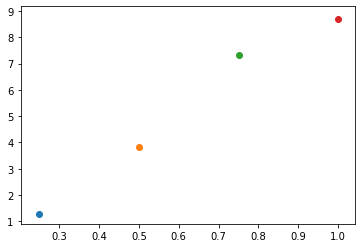

In [185]:
plt.scatter([0.25], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[0]]))
plt.scatter([0.50], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[1]]))
plt.scatter([0.75], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[2]]))
plt.scatter([1.00], np.mean([max(y[np.isfinite(y)]) for y in sig_improvements[3]]))
#add error bars

In [173]:
np.mean([max(y[~np.isnan(y)]) for y in sig_improvements[1]])

inf

In [ ]:
#add comments and fix up notebook format
#make functions of repetitive cells